In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path="/content/drive/MyDrive/DICOM"
inPath=os.listdir("/content/drive/MyDrive/DICOM")
inPath

['Pneumonia', 'Tuberculosis', 'Cancer']

In [ ]:
pneum_path=path+"/Pneumonia/Пневмония"
tub_path=path+"/Tuberculosis/Туберкулез"
can_path=path+"/Cancer/0"
print(pneum_path,
tub_path,
can_path)

/content/drive/MyDrive/DICOM/Pneumonia/Пневмония /content/drive/MyDrive/DICOM/Tuberculosis/Туберкулез /content/drive/MyDrive/DICOM/Cancer/0


In [ ]:
arrPneumPath=os.listdir(pneum_path)
arrTubPath=os.listdir(tub_path)
arrCanPath=os.listdir(can_path)

In [ ]:
def addPath(path, arrPath):
    arr=[]
    for i in range(0, len(arrPath)):
        inDirectory=os.listdir(path+"/"+arrPath[i])
        new_path=path+"/"+arrPath[i]
        for j in range(0, len(inDirectory)):
            inPostDirectory=os.listdir(new_path+"/"+inDirectory[j]+"/")
            for k in range(0, len(inPostDirectory)):
                end_pneum_path=new_path+"/"+inDirectory[j]+"/"+inPostDirectory[k]
                inLastDir=os.listdir(end_pneum_path)
                for m in range(0, len(inLastDir)):
                    endDir=end_pneum_path+"/"+inLastDir[m]
                    arr.append(endDir)
    return arr
arrPneum=addPath(pneum_path, arrPneumPath)
arrTub=addPath(tub_path, arrTubPath)
arrCan=addPath(can_path, arrCanPath)

In [ ]:
#установка библиотеки для работы с изображениями DICOM формата
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 37.2 MB/s 


In [ ]:
import pydicom as dicom
import cv2
from PIL import Image

In [ ]:

size=[]

def sizeCheked(arrPneum):
    pixel_array_numpy=[]
    for i in range(0, len(arrPneum)):
        try:
            image_path = arrPneum[i]
            ds = dicom.dcmread(image_path)
            pixel_array_numpy.append(ds.pixel_array)
        
            #image_format = '.jpg' # or '.png'
            #image_path = image_path.replace('.dcm', image_format)
            #im = Image.open(image_path)
            #size.append(im.size)
        except FileNotFoundError:
            print(i, ": none")
    for i in range(0, len(pixel_array_numpy)):
        for j in range(0, len(pixel_array_numpy[i])):
            if(pixel_array_numpy[i][j].size!=512):
                print(pixel_array_numpy[i][j].size)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
def spliting(arr):
    splitArray=[]
    for i in range(0,len(arr)):
        splitArray.append(arr[i].split('/'))
        
    return splitArray
spliter=spliting(arrPneum)+spliting(arrTub)+spliting(arrCan)

In [ ]:
preCsv=[]
for i in range(0,len(spliter)):
    preCsv.append([spliter[i][5], spliter[i][10], "/".join(spliter[i])])

In [ ]:
import pandas as pd
df = pd.DataFrame(preCsv)
df.to_csv('file.csv', index=False, header=True)

In [ ]:

df.columns = ['Type', 'img_name', 'path_to_img']
df

In [ ]:
import numpy as np

#функция перевода изображения в массив значений в единицах Хаунсфилда

def get_pixels_hu(scans):
    image = np.stack([scans.pixel_array])#np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # возможно, так как значения всегда должны быть достаточно низкими (<32k)
    image = image.astype(np.int16)

    # Установит значение пикселов вне области сканирования равным 1
    # intercept обычно составляет -1024, так что воздух составляет примерно 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans.RescaleIntercept
    slope = scans.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


In [ ]:
from skimage.transform import resize

In [ ]:
def get_pixel_uid(x):
    try:
        dcm_x=dicom.dcmread(x, force=True)
        #dcm_x.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
    
        return get_pixels_hu(dcm_x).flatten()
    except AttributeError:
        return None

In [ ]:
import tensorflow as tf

In [ ]:
path="/content/drive/MyDrive/UnetLern"
inPath=os.listdir(path)
inPath=inPath[1:]
inPath

['Cancer', 'Tuberculesis', 'Pneumonia']

In [ ]:
#выполняется сегментация, принудительно на графическом процессоре
with tf.device('/GPU:0'):
        df["img"]=df["path_to_img"].apply(lambda x: get_pixel_uid(x))

In [ ]:
#Standardize the pixel values
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from PIL import Image
import imageio
import cv2

def mask(img, img_name,diagnos, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    
    img = img-mean
    img = img/std
    # Найти среднее значение пикселя рядом с легкими
    # для перенормировки размытых изображений
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # 
    # 
    img[img==max]=mean
    img[img==min]=mean
    #
    # Использование Kmeans для разделения переднего плана (мягкие ткани / кости) и фона (легкие / воздух)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    #Получаю центр каждого кластера
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    threshold = np.mean(centers)
    
    thresh_img = np.where(img<threshold,1.0,0.0)  # пороговое значение изображения

    # Сначала удаляются более мелкие элементы, затем расширяются, чтобы включить некоторые пиксели, окружающие легкое. 
    # нельзя случайно задеть легкое.

    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(thresh_img,np.ones([8,8]))
    #Получение связанной области изображения
    labels = measure.label(dilation) # Разные части отображаются разными цветами
    
    #Получение уникальных областей
    label_vals = np.unique(labels)
    
    regions = measure.regionprops(labels)
    
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/14*13 and B[3]-B[1]<col_size/14*13 and B[0]>row_size/7 and B[2]<col_size/16*15:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  После того, как останутся только легкие, делаем еще одну операцию, чтобы заполнить и удалить легочную маску
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels, cmap='plasma')
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()


    #Отсюда идет поиск области интереса, а не легких
    dilation=dilation*255
    
    dilation=dilation.flatten()
    print(len(dilation))
    new_mask=[]
    for i in range(0, len(dilation)):
        new_mask.append(f_bin(dilation[i]))
    new_mask=np.asarray(new_mask).reshape(512,512)

    labels2 = measure.label(new_mask) # Разные части отображаются разными цветами
    
    #Получение уникальных областей
    label_vals2 = np.unique(labels2)
    
    regions2 = measure.regionprops(labels2)
    good_labels2=[]

    for prop in regions2:
        B = prop.bbox
        if B[2]-B[0]<row_size/20 and B[3]-B[1]<col_size/20 and B[0]>row_size/4 and B[2]<col_size/5*4:
            good_labels2.append(prop.label)
    mask2 = np.ndarray([row_size,col_size],dtype=np.int8)
    mask2[:] = 0

    #
    #  
    for N in good_labels2:
        mask2 = mask2 + np.where(labels2==N,1,0)
    print(good_labels2)

    mask2 = morphology.dilation(mask2,np.ones([10,10])) # one last dilation
    plt.imshow(mask2*img, cmap='gray')
    plt.axis("off")
    if(diagnos=="Cancer"):
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Cancer/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    if(diagnos=="Tuberculosis"):
        #im.save('/content/drive/MyDrive/UnetLern/Tuberculesis/'+img_name.replace('.dcm', '.jpeg'), img*mask)
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Tuberculesis/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    if(diagnos=="Pneumonia"):
        #im.save('/content/drive/MyDrive/Mask/Pneumonia/'+img_name+".jpg")
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Pneumonia/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    return mask*255

In [ ]:
prop=[]
import cv2
#подготовка снимков для Unet
for i in inPath:
    imgPath=os.listdir(path+"/"+i)
    amogus=path+"/"+i
    for j in range(0, len(imgPath)):
       prop.append([np.asarray(df[df['img_name'] == imgPath[j].replace('.jpeg', '.dcm')]['path_to_img'].tolist()).flatten(), cv2.imread(amogus+"/"+imgPath[j], cv2.IMREAD_GRAYSCALE)])
        #prop.append(df[df['img_name'] == j.replace('.jpeg', '.dcm')]['path_to_img'].tolist())

In [ ]:
for i in range(0, len(prop)):
    prop[i][0]=get_pixel_uid(prop[i][0][0].tolist()).reshape(512,512)
    prop[i][1]=prop[i][1]

In [ ]:
prop[i][0].shape

(512, 512)

In [ ]:
df_new = pd.DataFrame(prop)
df_new.columns=["img", "mask"]

In [ ]:
X=df_new["img"]
Y=df_new["mask"]

In [ ]:
from sklearn import preprocessing


normX=[]
for i in range(len(X)):
    normX.append(preprocessing.normalize(resize(X[i], (128,128))))

In [ ]:
normY=[]
for i in range(len(Y)):
    normY.append(resize(Y[i], (128,128)).astype('uint8'))

In [ ]:
normY[0].max()

1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(normX, normY, test_size=0.1, random_state=42)

In [ ]:
X_train=np.expand_dims(np.asarray(X_train), 3)
X_train.shape

(53, 128, 128, 1)

In [ ]:
X_valid=np.expand_dims(np.asarray(X_valid), 3)
X_valid.shape

(6, 128, 128, 1)

In [ ]:
y_train=np.expand_dims(np.asarray(y_train), 3)
y_train.shape

(53, 128, 128, 1)

In [ ]:
y_valid=np.expand_dims(np.asarray(y_valid), 3)
y_valid.shape

(6, 128, 128, 1)

In [ ]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/16_model')

In [ ]:
model_loaded.summary()

In [ ]:
result=model_loaded.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
2/2 [==============================] - 15s 2s/step - loss: 0.7623 - accuracy: 0.8180 - val_loss: 19.8988 - val_accuracy: 0.7996
Epoch 2/20
2/2 [==============================] - 0s 67ms/step - loss: 0.7583 - accuracy: 0.8180 - val_loss: 6.0858 - val_accuracy: 0.7623
Epoch 3/20
2/2 [==============================] - 0s 63ms/step - loss: 0.7550 - accuracy: 0.8179 - val_loss: 2.6815 - val_accuracy: 0.7250
Epoch 4/20
2/2 [==============================] - 0s 62ms/step - loss: 0.7510 - accuracy: 0.8180 - val_loss: 1.7144 - val_accuracy: 0.6944
Epoch 5/20
2/2 [==============================] - 0s 77ms/step - loss: 0.7476 - accuracy: 0.8180 - val_loss: 1.3768 - val_accuracy: 0.6739
Epoch 6/20
2/2 [==============================] - 0s 62ms/step - loss: 0.7443 - accuracy: 0.8179 - val_loss: 1.2234 - val_accuracy: 0.6576
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 0.7401 - accuracy: 0.8180 - val_loss: 1.1322 - val_accuracy: 0.6451
Epoch 8/20
2/2 [===========

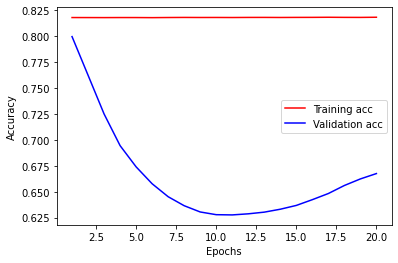

In [ ]:
import matplotlib.pyplot as plt
history_dict = result.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
one_test=resize(get_pixel_uid(df["path_to_img"][2720]).reshape(512,512), (128,128))

In [ ]:
one_test_norm=preprocessing.normalize(one_test)

In [ ]:
one_exp=np.expand_dims(np.expand_dims(one_test_norm, 0), 3)

In [ ]:
one_exp.shape

(1, 128, 128, 1)

In [ ]:
res=model_loaded.predict(one_exp)

In [ ]:
res2=res[0]
res2.shape

(128, 128, 1)

In [ ]:

res3=res2.reshape(128,128)

In [ ]:
res3.shape

(128, 128)

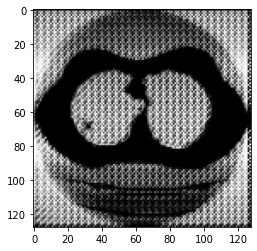

In [ ]:
plt.imshow(res3*255, cmap="gray")

In [ ]:
#Standardize the pixel values
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from PIL import Image
import imageio
import cv2

def mask(img, img_name,diagnos, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    
    img = img-mean
    img = img/std
    # Найти среднее значение пикселя рядом с легкими
    # для перенормировки размытых изображений
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # 
    # 
    img[img==max]=mean
    img[img==min]=mean
    #
    # Использование Kmeans для разделения переднего плана (мягкие ткани / кости) и фона (легкие / воздух)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    #Получаю центр каждого кластера
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    threshold = np.mean(centers)
    
    thresh_img = np.where(img<threshold,1.0,0.0)  # пороговое значение изображения

    # Сначала удаляются более мелкие элементы, затем расширяются, чтобы включить некоторые пиксели, окружающие легкое. 
    # нельзя случайно задеть легкое.

    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(thresh_img,np.ones([8,8]))
    #Получение связанной области изображения
    labels = measure.label(dilation) # Разные части отображаются разными цветами
    
    #Получение уникальных областей
    label_vals = np.unique(labels)
    
    regions = measure.regionprops(labels)
    
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/14*13 and B[3]-B[1]<col_size/14*13 and B[0]>row_size/7 and B[2]<col_size/16*15:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  После того, как останутся только легкие, делаем еще одну операцию, чтобы заполнить и удалить легочную маску
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels, cmap='plasma')
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()


    #Отсюда идет поиск области интереса, а не легких
    dilation=dilation*255
    
    dilation=dilation.flatten()
    print(len(dilation))
    new_mask=[]
    for i in range(0, len(dilation)):
        new_mask.append(f_bin(dilation[i]))
    new_mask=np.asarray(new_mask).reshape(512,512)

    labels2 = measure.label(new_mask) # Разные части отображаются разными цветами
    
    #Получение уникальных областей
    label_vals2 = np.unique(labels2)
    
    regions2 = measure.regionprops(labels2)
    good_labels2=[]

    for prop in regions2:
        B = prop.bbox
        if B[2]-B[0]<row_size/20 and B[3]-B[1]<col_size/20 and B[0]>row_size/4 and B[2]<col_size/5*4:
            good_labels2.append(prop.label)
    mask2 = np.ndarray([row_size,col_size],dtype=np.int8)
    mask2[:] = 0

    #
    #  
    for N in good_labels2:
        mask2 = mask2 + np.where(labels2==N,1,0)
    print(good_labels2)

    mask2 = morphology.dilation(mask2,np.ones([10,10])) # one last dilation
    plt.imshow(mask2*img, cmap='gray')
    plt.axis("off")
    if(diagnos=="Cancer"):
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Cancer/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    if(diagnos=="Tuberculosis"):
        #im.save('/content/drive/MyDrive/UnetLern/Tuberculesis/'+img_name.replace('.dcm', '.jpeg'), img*mask)
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Tuberculesis/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    if(diagnos=="Pneumonia"):
        #im.save('/content/drive/MyDrive/Mask/Pneumonia/'+img_name+".jpg")
        cv2.imwrite('/content/drive/MyDrive/UnetLern/Pneumonia/'+img_name.replace('.dcm', '.jpeg'), mask*255)
    return mask*255
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing
